In [1]:
from datasets import load_dataset
from transformers import AutoProcessor, LayoutLMv3ForTokenClassification, TrainingArguments, Trainer, AutoModelForTokenClassification
from transformers.data.data_collator import default_data_collator
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D, load_metric
from datasets.features import ClassLabel
from PIL import ImageDraw, ImageFont
import torch
import numpy as np

In [2]:
dataset = load_dataset("nielsr/funsd-layoutlmv3")

Found cached dataset funsd-layoutlmv3 (C:/Users/se200/.cache/huggingface/datasets/nielsr___funsd-layoutlmv3/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None)}

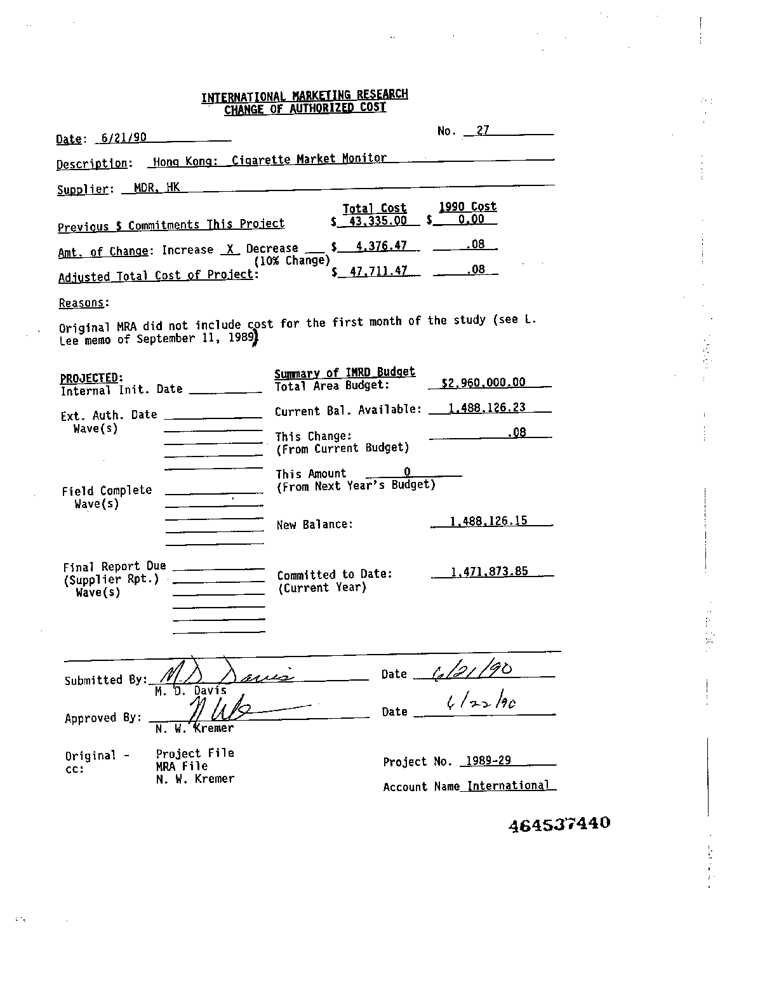

In [4]:
example = dataset["train"][20]
example["image"]

In [5]:
processor=AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [6]:
features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)
     

In [7]:
label2id

{'O': 0,
 'B-HEADER': 1,
 'I-HEADER': 2,
 'B-QUESTION': 3,
 'I-QUESTION': 4,
 'B-ANSWER': 5,
 'I-ANSWER': 6}

In [8]:
def prepare_examples(examples):
  images = examples[image_column_name]
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [9]:
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_dataset = dataset["train"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
eval_dataset = dataset["test"].map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Loading cached processed dataset at C:/Users/se200/.cache/huggingface/datasets/nielsr___funsd-layoutlmv3/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9\cache-ad0f8f6d904f061a.arrow
Loading cached processed dataset at C:/Users/se200/.cache/huggingface/datasets/nielsr___funsd-layoutlmv3/funsd/1.0.0/0e3f4efdfd59aa1c3b4952c517894f7b1fc4d75c12ef01bcc8626a69e41c1bb9\cache-e93b574520a83921.arrow


In [10]:
train_dataset.set_format("torch")

In [11]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [12]:
metric=load_metric('seqeval')

C:\Users\se200\AppData\Local\Temp\ipykernel_11660\1089079215.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric=load_metric('seqeval')


In [13]:
return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [14]:
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
training_args = TrainingArguments(output_dir="test",
                                  max_steps=20,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=10,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [17]:
trainer.train()

C:\Users\se200\anaconda31\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 20
  Number of trainable parameters = 125332359
C:\Users\se200\anaconda31\lib\site-packages\transformers\modeling_utils.py:768: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
10,No log,1.807466,0.082542,0.138102,0.103327,0.313206
20,No log,1.732186,0.126140,0.157973,0.140273,0.348627


***** Running Evaluation *****
  Num examples = 50
  Batch size = 2
***** Running Evaluation *****
  Num examples = 50
  Batch size = 2


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=20, training_loss=1.8317184448242188, metrics={'train_runtime': 1884.2232, 'train_samples_per_second': 0.021, 'train_steps_per_second': 0.011, 'total_flos': 10544213729280.0, 'train_loss': 1.8317184448242188, 'epoch': 0.27})

In [18]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 50
  Batch size = 2


{'eval_loss': 1.732185959815979,
 'eval_precision': 0.12614042046806823,
 'eval_recall': 0.15797317436661698,
 'eval_f1': 0.14027348919276575,
 'eval_accuracy': 0.3486271246879829,
 'eval_runtime': 127.172,
 'eval_samples_per_second': 0.393,
 'eval_steps_per_second': 0.197,
 'epoch': 0.27}

In [19]:
model=AutoModelForTokenClassification.from_pretrained("nielsr/layoutlmv3-finetuned-funsd")

loading configuration file config.json from cache at C:\Users\se200/.cache\huggingface\hub\models--nielsr--layoutlmv3-finetuned-funsd\snapshots\b447ff868f5c7e3fa154fbe12fbabb6ce9421187\config.json
Model config LayoutLMv3Config {
  "_name_or_path": "nielsr/layoutlmv3-finetuned-funsd",
  "architectures": [
    "LayoutLMv3ForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "finetuning_task": "ner",
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-HEADER",
    "2": "I-HEADER",
    "3": "B-QUESTION",
    "4": "I-QUESTION",
    "5": "B-ANSWER",
    "6": "I-ANSWER"
  },
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "label2id": {
    "B-ANSWER": 5,
    "B-HEADER": 1,
    "B-QUESTION": 3,
    "I-ANSWER"

In [20]:
example = dataset["test"][0]
print(example.keys())

dict_keys(['id', 'tokens', 'bboxes', 'ner_tags', 'image'])


In [21]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

input_ids torch.Size([1, 360])
attention_mask torch.Size([1, 360])
bbox torch.Size([1, 360, 4])
labels torch.Size([1, 360])
pixel_values torch.Size([1, 3, 224, 224])


In [22]:
with torch.no_grad():
  outputs = model(**encoding)

In [23]:
logits = outputs.logits
logits.shape

torch.Size([1, 360, 7])

In [24]:
predictions = logits.argmax(-1).squeeze().tolist()
labels = encoding.labels.squeeze().tolist()

In [25]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

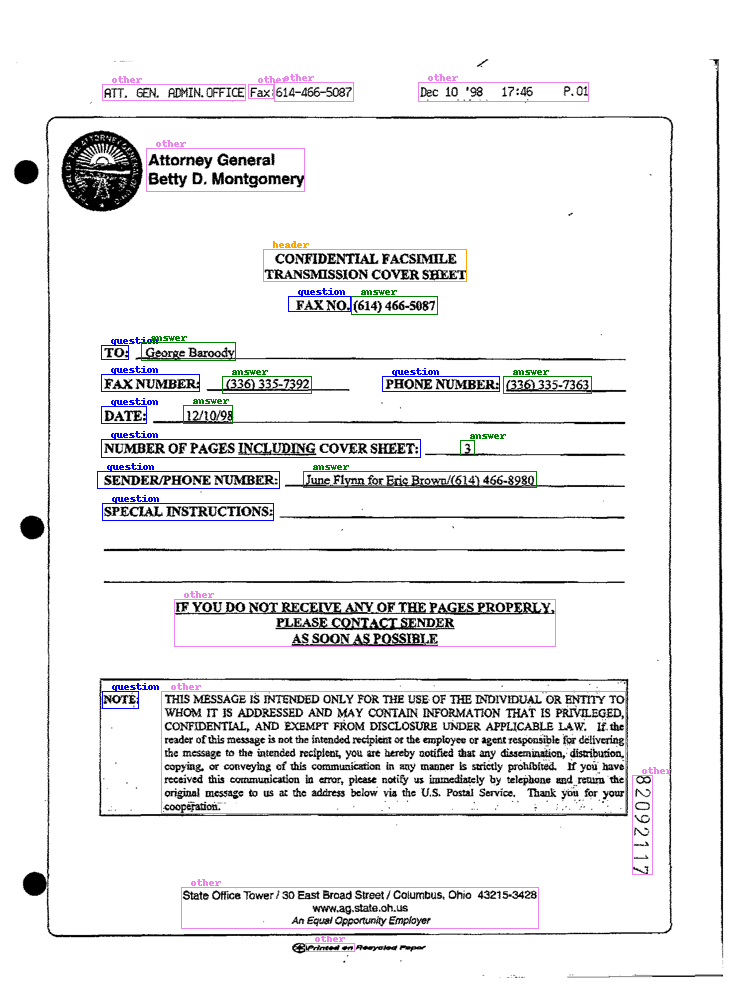

In [26]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image